In [7]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Load the data
df = pd.read_csv("../data/processed/sog_spawn_index.csv")

# 2. Normalize the values
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[["Total_CombinedSI"]])
data = torch.FloatTensor(scaled_values).view(-1)

# 3. Create input sequences
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

SEQ_LEN = 5
X, y = create_sequences(data, SEQ_LEN)
print("Input shape:", X.shape)  # Should be (n_samples, seq_len)

Input shape: torch.Size([66, 5])


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = x.unsqueeze(-1)  # Add feature dimension: (batch_size, seq_len, 1)
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Use output from last time step
        return self.linear(last_output)

In [9]:
# Create model instance
model = LSTMModel()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
EPOCHS = 300
losses = []

for epoch in range(EPOCHS):
    model.train()

    output = model(X)
    loss = criterion(output.squeeze(), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.1301
Epoch 50, Loss: 0.0247
Epoch 100, Loss: 0.0203
Epoch 150, Loss: 0.0142
Epoch 200, Loss: 0.0100
Epoch 250, Loss: 0.0092


In [10]:
# Get the last 5 values to predict the next year
last_seq = data[-5:].unsqueeze(0)  # shape: (1, 5)

model.eval()
with torch.no_grad():
    next_pred_scaled = model(last_seq).item()

# Inverse transform the scaled value to real-world units
next_pred = scaler.inverse_transform([[next_pred_scaled]])[0][0]
print(f"Predicted next year spawning index: {next_pred:.2f}")

Predicted next year spawning index: 153434.65


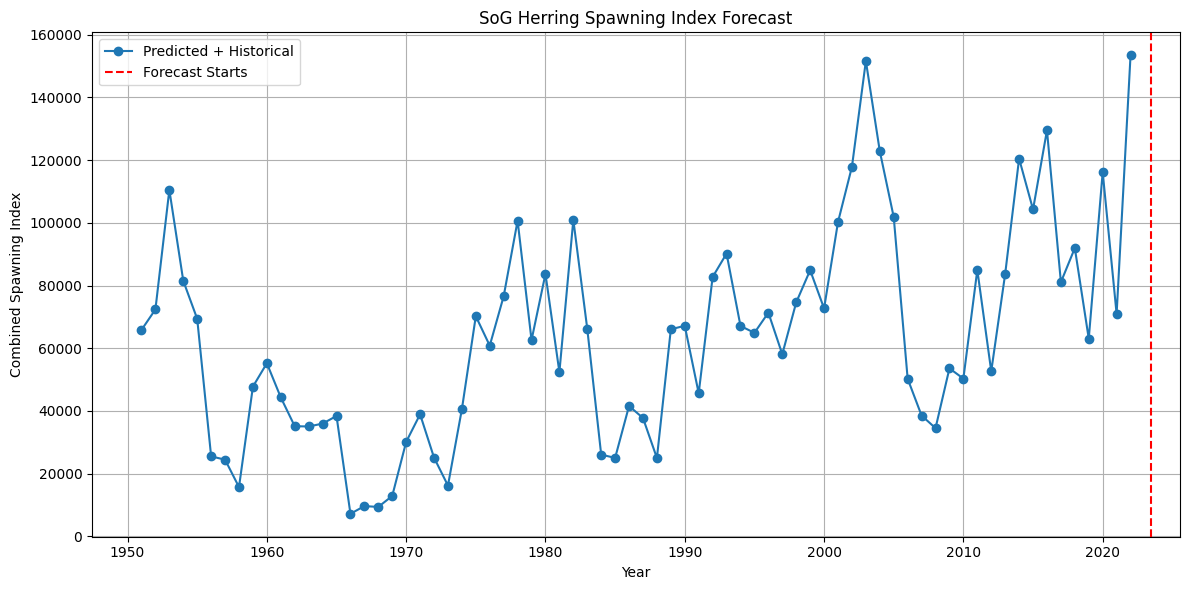

In [12]:
# Historical values
years = df["Year"].tolist()
values = df["Total_CombinedSI"].tolist()

# Add the predicted next year
years.append(years[-1] + 1)
values.append(next_pred)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(years, values, marker="o", label="Predicted + Historical")
plt.axvline(x=2023.5, color="red", linestyle="--", label="Forecast Starts")
plt.title("SoG Herring Spawning Index Forecast")
plt.xlabel("Year")
plt.ylabel("Combined Spawning Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()